## Мультиадронный генератор. Фит

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [43]:
exp_tree = uproot.open(f'../trees/19/multihadrons.root')['t']
mc_tree = uproot.open(f'../trees/19/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=True)
df_mc = preprocess.read_tree(mc_tree, mc=True)

In [46]:
energies_list = df_exp.index.unique().intersection(df_mc.index.unique())
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

550.0 700.0 950.0 

In [38]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (2000, (0.1, None)),
    'n_bkg': (  10, (0, None)),    
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'k'    : ( 0.1, (0, None)),
}

In [86]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM

def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 2*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [77]:
e0 = next(it)
print(f'Energy {e0} MeV')

Energy 950.0 MeV


In [87]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse()
assert m_mc.valid

params_exp = get_params_exp(params, m_mc, ['n_sig', 'n_bkg', 'k', 'm'])
params_exp['n_sig'] = (len(dataE[(dataE>-40)&(dataE<20)])*0.9, (0, None))
# params_exp['n_bkg'] = (len(dataE[(dataE>-40)&(dataE<20)])*1, (0, None))
# params_exp['k'] = (0, (0, 0))
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse()
assert m_exp.valid

In [88]:
n0 = dfE.query('(x1>-40)&(x1<20)').shape[0]
nsig = dfE.query('(x1>-40)&(x1<20)&(sim_parts=="$K_L$$K_S$")').shape[0]
print(f'Nsig = {nsig}; Nbkg = {n0-nsig}')

Nsig = 48; Nbkg = 3


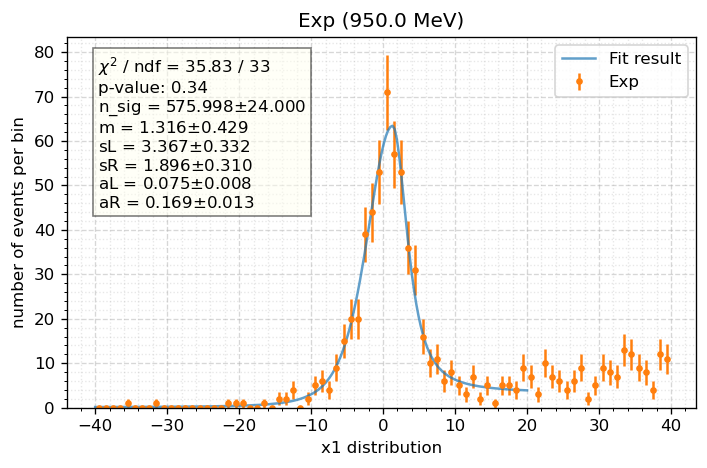

In [89]:
pys.plot_fit(dataM, cost_mc, m_mc, 80, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)

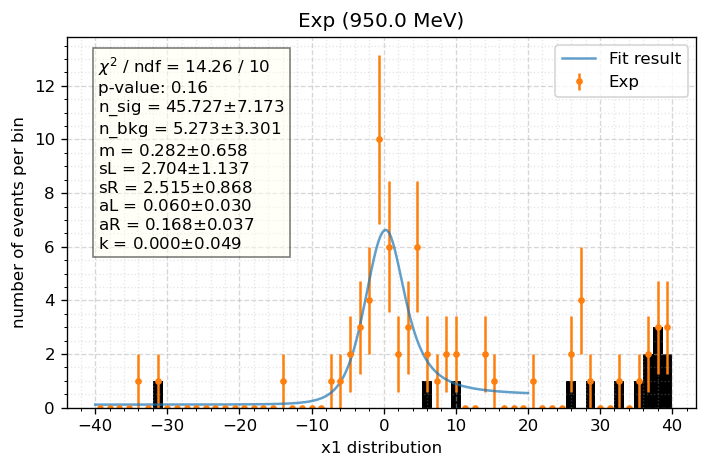

In [90]:
bins = 60
pys.plot_fit(dataE, cost_exp, m_exp, bins, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
plt.hist(dfE.query("sim_parts!='$K_L$$K_S$'").x1, range=hist_range, bins=bins, color='black');